In [1]:
import sys

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/
    # ! rm -r LastFM/
    # ! git clone https://github.com/TimofeevAlex/LastFM.git
    sys.path.append('/content/gdrive/MyDrive/LastFM/src')
else:
    sys.path.append('src')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


In [3]:
import os
import sys
from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import clear_output

from train_test import train_test_split
from models import create_neumf_model, create_neumf_model_si
from neumf_helpers import create_train_step, create_test_step, create_inference, \
                        train_one_step, valid_one_step, test_one_epoch, plot_metrics
from metrics import compute_metrics

%load_ext autoreload
%autoreload 2

seed=0
np.random.seed(seed)

It is impossible to merge datasets because of their sizes

In [4]:
train = pd.read_csv('lastfm-dataset-360K/train.csv')
valid = pd.read_csv('lastfm-dataset-360K/valid.csv')
test = pd.read_csv('lastfm-dataset-360K/test.csv')
lastfm_360_behav = pd.read_csv('lastfm-dataset-360K/behav-360k-processed.csv')
lastfm_360_demo = pd.read_csv('lastfm-dataset-360K/demo-360k-processed.csv')
lastfm_360_demo = lastfm_360_demo.set_index('user_email').astype(bool)
test_users = np.load('lastfm-dataset-360K/test_users.npy')

In [5]:
artists = train['artist_id'].unique()
users = lastfm_360_demo.index.unique()

In [7]:
num_artists = artists.max()
num_users = users.max()
num_user_features = lastfm_360_demo.shape[1] 
num_factors = 16
batch_size = 2 ** 16
k=10
threshold = 0.1 

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train)
train_dataset = train_dataset.batch(batch_size).shuffle(train.shape[0], seed=0, reshuffle_each_iteration=True)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid)
valid_dataset = valid_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test)
test_dataset = test_dataset.batch(batch_size)

In [10]:
# tf.keras.utils.plot_model(model, show_shapes=False, dpi=300)
# plt.savefig('nlf_model_vertical.png')

<Figure size 432x288 with 0 Axes>

# Basic experiments

### NeuMF without side information

In [9]:
model = create_neumf_model(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

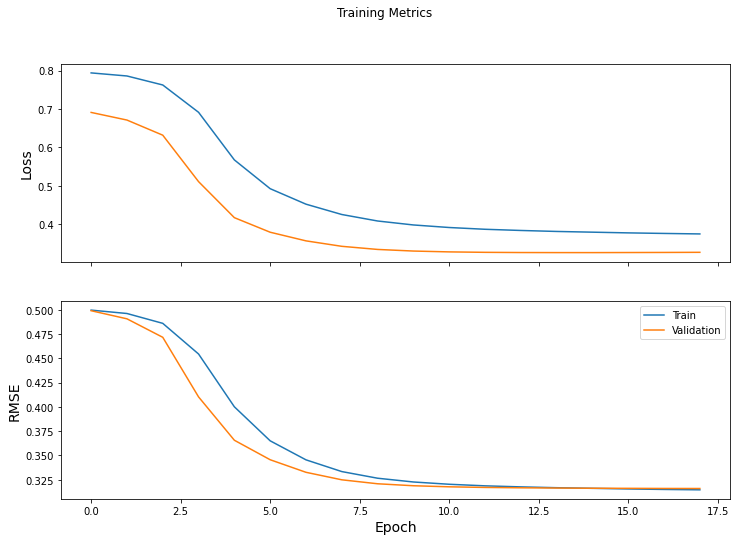

In [13]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, epoch_loss_avg, epoch_rmse, si=False)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, val_loss_avg, val_rmse, si=False)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, log_frequency, timenow)


In [15]:
# model = tf.keras.models.load_model('saved_model/2021-05-16 20:01:08.830391/model_20')

In [16]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=False)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.20295529
Test RMSE: 0.25280124


In [19]:
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.29197404422648504
Recall    @ 10: 0.5927733991832866
Ndcg @ 10: 0.6409288881658398
Hit rate: 2.903757307537042
Arhr: 1.1632604816417103


### NeuMF with side information

In [9]:
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

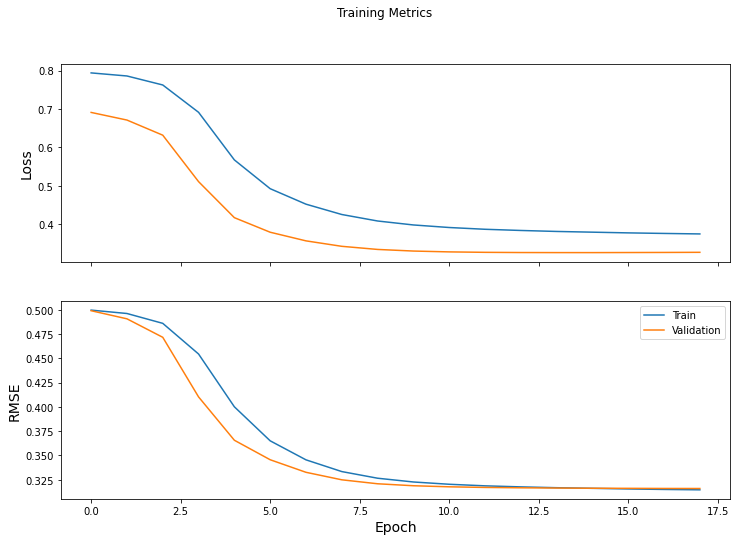

In [13]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, epoch_loss_avg, epoch_rmse, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, val_loss_avg, val_rmse, si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, log_frequency, timenow)


In [15]:
# model = tf.keras.models.load_model('saved_model/2021-05-16 20:01:08.830391/model_20')

In [16]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.20295529
Test RMSE: 0.25280124


In [19]:
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.29197404422648504
Recall    @ 10: 0.5927733991832866
Ndcg @ 10: 0.6409288881658398
Hit rate: 2.903757307537042
Arhr: 1.1632604816417103


# Different number of negative samples

### NeuMF with side information, negative samples = 0.5x positive samples 

In [ ]:
negative_train = train[train['ratings'] == 0]
negative_train = negative_train.sample(negative_train.shape[0] // 2)
train_half = train.drop(negative_train.index)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_half)
train_dataset = train_dataset.batch(batch_size).shuffle(train_half.shape[0], seed=0, reshuffle_each_iteration=True)

In [9]:
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

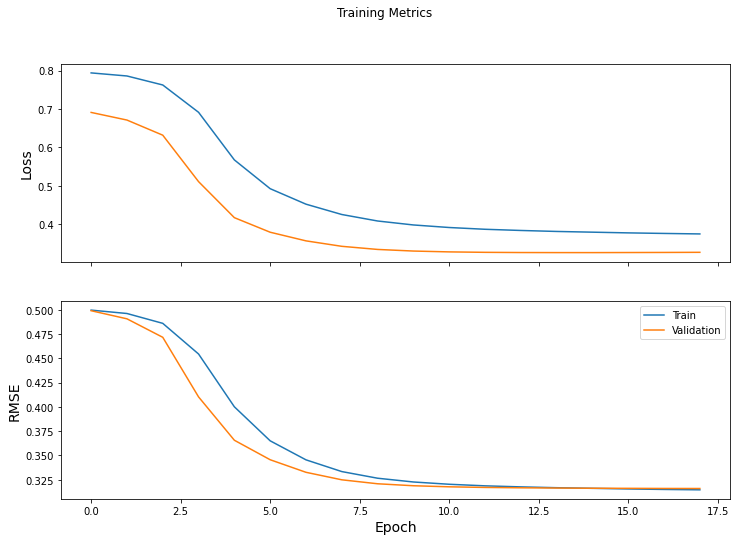

In [13]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, epoch_loss_avg, epoch_rmse, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, val_loss_avg, val_rmse, si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, log_frequency, timenow)


In [15]:
# model = tf.keras.models.load_model('saved_model/2021-05-16 20:01:08.830391/model_20')

In [16]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.20295529
Test RMSE: 0.25280124


In [19]:
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.29197404422648504
Recall    @ 10: 0.5927733991832866
Ndcg @ 10: 0.6409288881658398
Hit rate: 2.903757307537042
Arhr: 1.1632604816417103


### NeuMF with side information, negative samples = 2x positive samples 

In [ ]:
ratings = train.append(valid).append(test)
all_artists = set(ratings['artist_id'].unique())
get_negative_ratings = build_get_negative_ratings(all_artists, factor=1)
negative_ratings = ratings.groupby('user_email').progress_apply(get_negative_ratings)
negative_ratings = negative_ratings.reset_index().drop(columns='level_1')
train_twice = train.append(negative_ratings)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_twice)
train_dataset = train_dataset.batch(batch_size).shuffle(train_twice.shape[0], seed=0, reshuffle_each_iteration=True)

In [9]:
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

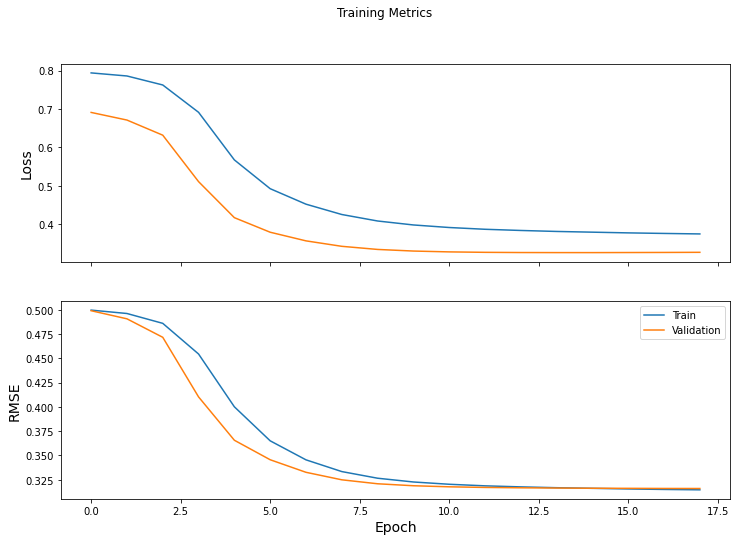

In [13]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, epoch_loss_avg, epoch_rmse, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, val_loss_avg, val_rmse, si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, log_frequency, timenow)


In [15]:
# model = tf.keras.models.load_model('saved_model/2021-05-16 20:01:08.830391/model_20')

In [16]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.20295529
Test RMSE: 0.25280124


In [19]:
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.29197404422648504
Recall    @ 10: 0.5927733991832866
Ndcg @ 10: 0.6409288881658398
Hit rate: 2.903757307537042
Arhr: 1.1632604816417103


# Cold start

Don't split on validation and test because we don't adjust hyperparameters

In [ ]:
ratings = train.append(valid).append(test)
test_indices = ratings['user_email'].isin(test_users)
test_cold = ratings[ratings['user_email'].isin(test_users)]
train_cold = train[~train['user_email'].isin(test_users)]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_cold)
train_dataset = train_dataset.batch(batch_size).shuffle(train_cold.shape[0], seed=0, reshuffle_each_iteration=True)
test_dataset = tf.data.Dataset.from_tensor_slices(test_cold)
test_dataset = test_dataset.batch(batch_size)

### NeuMF without side information

In [9]:
model = create_neumf_model(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

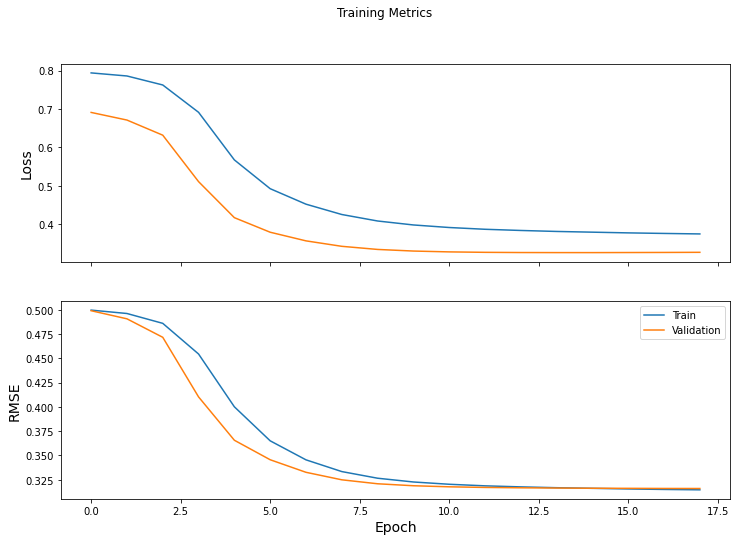

In [13]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
test_loss_results = []
test_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, epoch_loss_avg, epoch_rmse, si=False)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=False)
        test_loss_results.append(loss)
        test_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, test_loss_results, test_rmse_results, log_frequency, timenow)


In [15]:
# model = tf.keras.models.load_model('saved_model/2021-05-16 20:01:08.830391/model_20')

In [16]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=False)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.20295529
Test RMSE: 0.25280124


In [19]:
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.29197404422648504
Recall    @ 10: 0.5927733991832866
Ndcg @ 10: 0.6409288881658398
Hit rate: 2.903757307537042
Arhr: 1.1632604816417103


### NeuMF with side information

In [9]:
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

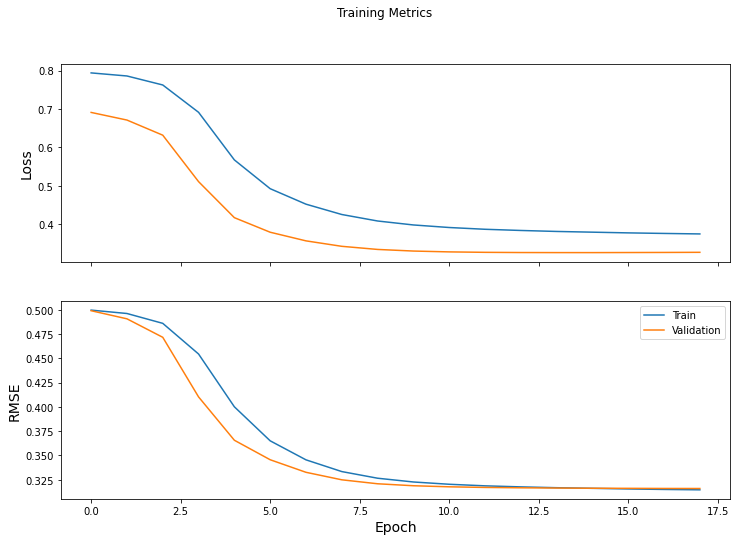

In [13]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
test_loss_results = []
test_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, epoch_loss_avg, epoch_rmse, si=False)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=False)
        test_loss_results.append(loss)
        test_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, test_loss_results, test_rmse_results, log_frequency, timenow)


In [15]:
# model = tf.keras.models.load_model('saved_model/2021-05-16 20:01:08.830391/model_20')

In [16]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, test_loss_avg, test_rmse, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.20295529
Test RMSE: 0.25280124


In [19]:
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.29197404422648504
Recall    @ 10: 0.5927733991832866
Ndcg @ 10: 0.6409288881658398
Hit rate: 2.903757307537042
Arhr: 1.1632604816417103
